<a href="https://colab.research.google.com/github/musticevik/ECG-ML/blob/main/yap470_ecg_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cardiac Disease Prediction from ECG

## Data Preprocessing

In [ ]:
import numpy as np
import pandas as pd
import os
from scipy.io import loadmat
from scipy.signal import butter, filtfilt, find_peaks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import multilabel_confusion_matrix
from matplotlib.colors import LinearSegmentedColormap
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

## Visualization of Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Klasör işleniyor: /content/drive/MyDrive/g1
Toplam .hea dosya sayısı: 999

Toplanan toplam hastalık kodu sayısı: 2224
Benzersiz hastalık kodu sayısı: 53


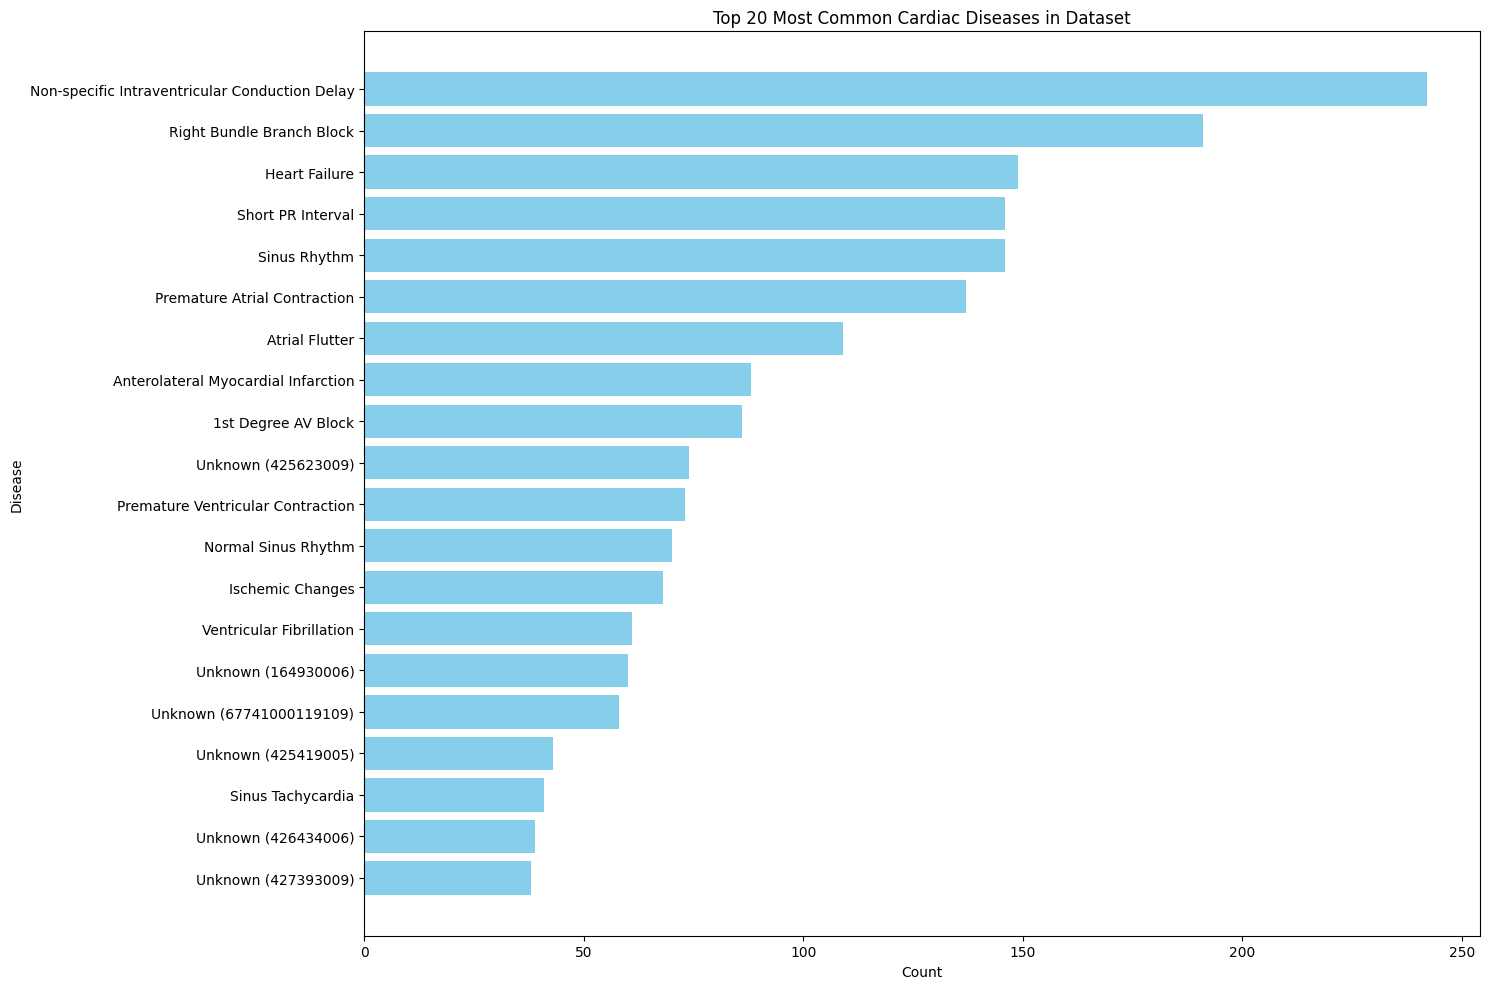


Hastalık dağılımı:
Non-specific Intraventricular Conduction Delay: 242
Right Bundle Branch Block: 191
Heart Failure: 149
Short PR Interval: 146
Sinus Rhythm: 146
Premature Atrial Contraction: 137
Atrial Flutter: 109
Anterolateral Myocardial Infarction: 88
1st Degree AV Block: 86
Unknown (425623009): 74
Premature Ventricular Contraction: 73
Normal Sinus Rhythm: 70
Ischemic Changes: 68
Ventricular Fibrillation: 61
Unknown (164930006): 60
Unknown (67741000119109): 58
Unknown (425419005): 43
Sinus Tachycardia: 41
Unknown (426434006): 39
Unknown (427393009): 38
T-Wave Abnormality: 38
Unknown (713426002): 29
Bradycardia: 29
ST Depression: 25
Right Atrial Enlargement: 20
Atrial Tachycardia: 18
Atrial Fibrillation: 18
Acute Myocardial Infarction: 16
Right Bundle Branch Block (RBBB): 16
Hypertrophic Cardiomyopathy: 13
Bifascicular Block: 13
Atrioventricular Dissociation: 11
Unknown (89792004): 7
Unknown (266249003): 7
Unknown (251268003): 6
Unknown (195126007): 5
Inferior Myocardial Infarction

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter

# SNOMED kodları aynı kalacak
snomed_diseases = {
    "164865005": "Atrial Fibrillation",
    "164873001": "Atrial Flutter",
    "164861001": "Ventricular Tachycardia",
    "426627000": "Complete Heart Block",
    "713427006": "Anterior Myocardial Infarction",
    "445118002": "Hypertrophic Cardiomyopathy",
    "394659003": "Mitral Insufficiency",
    "253352002": "Right Bundle Branch Block (RBBB)",
    "251120003": "Left Bundle Branch Block (LBBB)",
    "282825002": "Angina Pectoris",
    "164890007": "Atrial Fibrillation",
    "428750005": "Heart Failure",
    "426177001": "Sinus Rhythm",
    "428417006": "Acute Myocardial Infarction",
    "55827005": "Left Ventricular Hypertrophy",
    "426783006": "Right Bundle Branch Block",
    "164889003": "Normal Sinus Rhythm",
    "427084000": "Premature Atrial Contraction",
    "164934002": "Non-specific Intraventricular Conduction Delay",
    "39732003": "Ischemic Changes",
    "429622005": "Inferior Myocardial Infarction",
    "59931005": "1st Degree AV Block",
    "164912004": "Sinus Bradycardia",
    "698252002": "ST Depression",
    "59118001": "Sinus Tachycardia",
    "164917005": "Premature Ventricular Contraction",
    "164909002": "Atrial Tachycardia",
    "17338001": "T-Wave Abnormality",
    "270492004": "Ventricular Fibrillation",
    "164931005": "Right Atrial Enlargement",
    "284470004": "Anterolateral Myocardial Infarction",
    "251146004": "Bradycardia",
    "251199005": "Left Atrial Enlargement",
    "164865005": "Atrial Flutter",
    "251180001": "Ventricular Tachycardia",
    "233917008": "Atrioventricular Dissociation",
    "111975006": "Short PR Interval",
    "251173003": "Long QT Syndrome",
    "47665007": "Bifascicular Block",
    "164937009": "Hyperkalemia",
    "164947007": "Hypokalemia"
}

data_path = '/content/drive/MyDrive/g1'
diseases = []

print(f"Klasör işleniyor: {data_path}")
try:
    files = os.listdir(data_path)
    hea_files = [f for f in files if f.endswith('.hea')]
    print(f"Toplam .hea dosya sayısı: {len(hea_files)}")

    for filename in hea_files:
        header_path = os.path.join(data_path, filename)
        try:
            with open(header_path, 'r') as file:
                lines = file.readlines()

                for line in lines:
                    # strip() ile başındaki ve sonundaki boşlukları temizle
                    # "# Dx:" formatını kontrol et
                    if line.strip().startswith("# Dx:"):
                        # print(f"Dx satırı bulundu ({filename}): {line.strip()}")
                        # "# Dx:" kısmından sonrasını al
                        dx_part = line.split("# Dx:")[1].strip()
                        # Virgülle ayır ve boşlukları temizle
                        dx_codes = [code.strip() for code in dx_part.split(",")]
                        diseases.extend(dx_codes)

        except Exception as e:
            print(f"Dosya okuma hatası ({filename}): {e}")

except Exception as e:
    print(f"Klasör okuma hatası: {e}")

print(f"\nToplanan toplam hastalık kodu sayısı: {len(diseases)}")
print(f"Benzersiz hastalık kodu sayısı: {len(set(diseases))}")

# Hastalık sayımı ve görselleştirme
disease_counts = Counter(diseases)
disease_names = {}
for code, count in disease_counts.items():
    name = snomed_diseases.get(code, f"Unknown ({code})")
    if name in disease_names:
        disease_names[name] += count
    else:
        disease_names[name] = count

# DataFrame oluştur ve sırala
df = pd.DataFrame(disease_names.items(), columns=["Disease", "Count"])
df = df.sort_values(by="Count", ascending=False)

# İlk 20 hastalığı göster
plt.figure(figsize=(15, 10))
plt.barh(df["Disease"][:20], df["Count"][:20], color="skyblue")
plt.xlabel("Count")
plt.ylabel("Disease")
plt.title("Top 20 Most Common Cardiac Diseases in Dataset")
plt.gca().invert_yaxis()  # Büyükten küçüğe sırala
plt.tight_layout()
plt.show()

# Sayısal dağılımı yazdır
print("\nHastalık dağılımı:")
for disease, count in df.values:
    print(f"{disease}: {count}")

### 1. Filtering ECG to Remove Noise

In [ ]:
def filter_ecg(ecg_data, low_cutoff, high_cutoff, fs):
    def butter_bandpass(lowcut, highcut, fs, order=1):
        nyquist = 0.5 * fs
        low = lowcut / nyquist
        high = highcut / nyquist
        b, a = butter(order, [low, high], btype='band')
        return b, a

    def apply_bandpass_filter(ecg_data, lowcut, highcut, fs, order=1):
        b, a = butter_bandpass(lowcut, highcut, fs, order)
        ecg_filtered = filtfilt(b, a, ecg_data)  # Using filtfilt to avoid phase distortion
        return ecg_filtered

    ecg_filtered = apply_bandpass_filter(ecg_data, low_cutoff, high_cutoff, fs)

    return ecg_filtered

#### ECG Filtering Visualization

In [ ]:
def get_sample_frequency(header_path):
      with open(header_path, "r") as file:
        line = file.readline()
        return line.split(" ")[2] # Sample frequency value

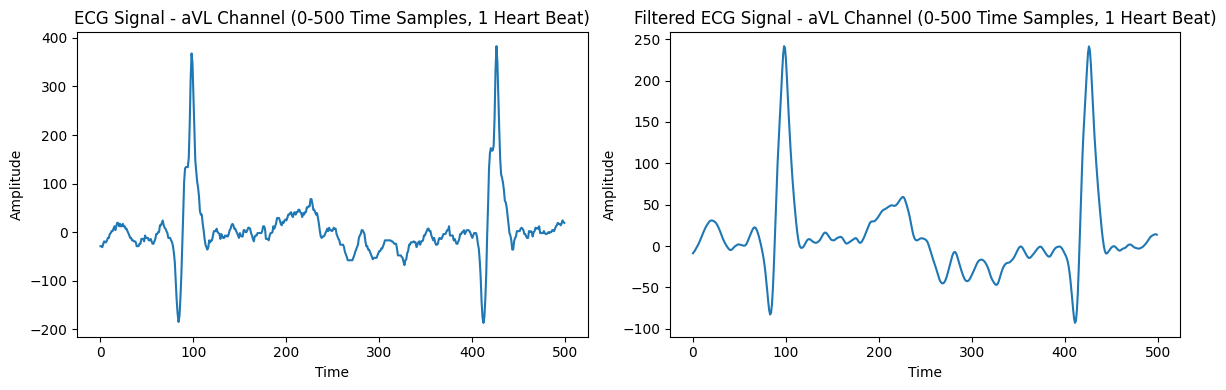

In [ ]:
temp_ecg = []
fs = 1000 # Common sample frequency value
for filename in os.listdir(data_path):
        if filename.endswith(".mat"):
            mat_path = os.path.join(data_path,filename)
            mat_data = loadmat(mat_path)
            temp_ecg = mat_data['val']
            header_path = mat_path.replace(".mat", ".hea")
            fs = int(get_sample_frequency(header_path))

temp_filtered_ecg = filter_ecg(temp_ecg, 0.5, 50, 1000) # Sample frequency: 1000, lowcut = 0.5, highcut = 50

fig, axs = plt.subplots(1, 2, figsize=(12,4))

axs[0].plot(temp_ecg[4,0:fs]) # aVL channel is the 5th (4th index) channel of 12-Channel-ECG
axs[0].set_title(f"ECG Signal - aVL Channel (0-{fs} Time Samples, 1 Heart Beat)")
axs[0].set_xlabel("Time")
axs[0].set_ylabel("Amplitude")

axs[1].plot(temp_filtered_ecg[4,0:fs])
axs[1].set_title(f"Filtered ECG Signal - aVL Channel (0-{fs} Time Samples, 1 Heart Beat)")
axs[1].set_xlabel("Time")
axs[1].set_ylabel("Amplitude")

plt.tight_layout()
plt.show()


### 2. Feature Extraction

#### Get Patient's Age and Sex Info from Header File

In [ ]:
def get_patient_info(header_path):
    age, sex = None, None
    with open(header_path, 'r') as file:
        lines = file.readlines()
        for line in lines:
            if line.startswith("#Age"):
                age = line.split(":")[1].strip()
            elif line.startswith("#Sex"):
                sex = line.split(":")[1].strip()

    # Default values for missing data
    if age is None:
        age = -1
    if sex is None:
        sex = 'unknown'

    sex = 0 if sex.lower() == 'male' else 1 # Convert sex string to a numeric value

    try:
        age = float(age)  # Ensure that age is a numeric value
    except ValueError:
        age = 0

    return age, sex

In [ ]:
def extract_features(ecg_data, header_path, fs):
    features = []
    for i in range(ecg_data.shape[0]):
        lead_data = ecg_data[i,:]
        peaks, _ = find_peaks(lead_data, height=0.5, distance=fs/2) # Calculate peaks
        rr_intervals = np.diff(peaks) / fs

        heart_rate = len(peaks) * (60 / ((len(lead_data)) / fs)) # BPM
        avg_rr_interval = np.mean(rr_intervals) if len(rr_intervals) > 0 else 0
        std_rr_interval = np.std(rr_intervals) if len(rr_intervals) > 0 else 0

        age, sex = get_patient_info(header_path)

        features.append([heart_rate, avg_rr_interval, std_rr_interval, age, sex])

    return np.array(features)

### 3. Creating Dataset

#### Extract Disease Code from Header File

In [ ]:
def extract_disease_code(header_path):
    with open(header_path, "r") as file:
        lines = file.readlines()
        for line in lines:
            if line.startswith("#Dx"): # Dx indicates cardiac disease number
                return line.split(":")[1].strip().split(",")

In [ ]:
def prepare_dataset(data_path):
    data = []
    labels = []
    index = 0
    for filename in os.listdir(data_path):
        if filename.endswith(".mat"):
            mat_path = os.path.join(data_path,filename)
            mat_data = loadmat(mat_path)
            ecg_data = mat_data['val']

            # Label Extracting
            header_path = mat_path.replace(".mat", ".hea")
            label = extract_disease_code(header_path)

            fs = int(get_sample_frequency(header_path))

            # Filtering ECG Signals
            ecg_filtered = filter_ecg(ecg_data, 0.5, 50, fs)

            # Feature Extracting
            features = extract_features(ecg_filtered, header_path, fs)

            # Assemble Dataset
            for feature in features:
                data.append(feature)
                labels.append(label)


            print(f"\r{index} / {len(os.listdir(data_path)) / 2}",end="")
            index = index + 1
            if index == 6000:
                break

    # Create DataFrame
    df = pd.DataFrame(data, columns=["heart_rate", "avg_rr_interval", "std_rr_interval", "age", "sex"])
    df['label'] = labels

    # Convert age and sex values into numeric
    df['age'] = pd.to_numeric(df['age'], errors='coerce')
    df['sex'] = pd.to_numeric(df['sex'], errors='coerce')

    # Fill NaN values
    df['age'] = df['age'].fillna(df['age'].mean())  # Fill with mean
    df['sex'] = df['sex'].fillna(df['sex'].mode()[0])  # Fill with common value

    return df

#### Preparing Dataset

### 4. Load Data

In [ ]:
data_paths = [
    #"/kaggle/input/ptb-diagnostic-ecg-database/Training_PTB/",
    #"/kaggle/input/shaoxing-and-ningbo-first-hospital-database/WFDB_ShaoxingUniv/"
  data_path
]

def merge_datasets(data_paths):
    all_data = []
    for data_path in data_paths:
        df = prepare_dataset(data_path)
        all_data.append(df)

    merged_df = pd.concat(all_data, ignore_index=True)
    return merged_df

df = merge_datasets(data_paths)

998 / 999.5

#### Label Encoding

In [ ]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer

# ... (your existing code to load and prepare the dataframe) ...

df = df.rename(columns={'label': 'labels'})

# Replace None values in 'labels' column with empty lists
df['labels'] = df['labels'].apply(lambda x: [] if x is None else x)

mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(df['labels'])
labels_df = pd.DataFrame(labels, columns=mlb.classes_)

df = pd.concat([df.drop('labels', axis=1), labels_df], axis=1)

In [ ]:
#df = df.rename(columns={'label': 'labels'})
#mlb = MultiLabelBinarizer()
#labels = mlb.fit_transform(df['labels'])
#labels_df = pd.DataFrame(labels, columns=mlb.classes_)

#df = pd.concat([df.drop('labels', axis=1), labels_df], axis=1)

### 5. Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split

X = df.drop(mlb.classes_, axis=1)
y = df[mlb.classes_]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

### 6. Training and Evaluation of Models

In [ ]:
# Sinir Ağı Modelini Tanımlama
ann_model = Sequential()
ann_model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))  # input_dim kullanıyoruz
ann_model.add(Dense(32, activation='relu'))
ann_model.add(Dense(len(mlb.classes_), activation='sigmoid'))  # Çıkış katmanında sigmoid kullanıyoruz

# Modeli Derleme
ann_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Modeli Eğitme
ann_history = ann_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Modelin Değerlendirilmesi
y_pred_ann = ann_model.predict(X_test)
y_pred_ann_bin = (y_pred_ann > 0.5).astype(int)  # Thresholding ile tahminleri binarize et

plt.figure(figsize=(12, 5))

# Loss grafiği
plt.subplot(1, 2, 1)
plt.plot(ann_history.history['loss'], label='Train Loss')
plt.plot(ann_history.history['val_loss'], label='Validation Loss')
plt.title('Loss Grafiği')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy grafiği
plt.subplot(1, 2, 2)
plt.plot(ann_history.history['accuracy'], label='Train Accuracy')
plt.plot(ann_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Grafiği')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20


InvalidArgumentError: Graph execution error:

Detected at node ArgMax defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 377, in dispatch_queue

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 250, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 748, in __init__

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-75-085ddd879f50>", line 11, in <cell line: 11>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 318, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 108, in one_step_on_data

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 77, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/trainers/trainer.py", line 444, in compute_metrics

  File "/usr/local/lib/python3.10/dist-packages/keras/src/trainers/compile_utils.py", line 330, in update_state

  File "/usr/local/lib/python3.10/dist-packages/keras/src/trainers/compile_utils.py", line 17, in update_state

  File "/usr/local/lib/python3.10/dist-packages/keras/src/metrics/reduction_metrics.py", line 204, in update_state

  File "/usr/local/lib/python3.10/dist-packages/keras/src/metrics/accuracy_metrics.py", line 136, in categorical_accuracy

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/numpy.py", line 869, in argmax

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/numpy.py", line 772, in argmax

Reduction axis -1 is empty in shape [32,0]
	 [[{{node ArgMax}}]] [Op:__inference_one_step_on_iterator_1409]

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define your models with multilabel support
models = {
    "KNN": OneVsRestClassifier(KNeighborsClassifier(n_neighbors=5)),
    "SVM": OneVsRestClassifier(SVC(kernel='rbf')),
    "RandomForest": OneVsRestClassifier(RandomForestClassifier(n_estimators=100))
}

# Results dataframe
results_df = pd.DataFrame(columns=["Model", "Train Accuracy", "Train Precision", "Train Recall", "Train F1-Score",
                                   "Validation Accuracy", "Validation Precision", "Validation Recall", "Validation F1-Score",
                                   "Test Accuracy", "Test Precision", "Test Recall", "Test F1-Score"])

for idx, (name, model) in enumerate(models.items()):
    # Fit the model
    model.fit(X_train, y_train)

    # Predict on Train, Validation, and Test sets
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)

    # Get disease codes as class labels
    class_labels = y_test.columns

    # Calculate classification reports
    train_report = classification_report(y_train, y_train_pred, output_dict=True, zero_division=1)
    val_report = classification_report(y_val, y_val_pred, output_dict=True, zero_division=1)
    test_report = classification_report(y_test, y_test_pred, output_dict=True, zero_division=1)

    # Extract metrics from the classification report
    def get_metrics(report, y_true, y_pred):
        return {
            "Accuracy": accuracy_score(y_true, y_pred),
            "Precision": report["weighted avg"]["precision"],
            "Recall": report["weighted avg"]["recall"],
            "F1-Score": report["weighted avg"]["f1-score"]
        }

    # Get metrics for train, validation, and test sets
    train_metrics = get_metrics(train_report, y_train, y_train_pred)
    val_metrics = get_metrics(val_report, y_val, y_val_pred)
    test_metrics = get_metrics(test_report, y_test, y_test_pred)

    # Create a DataFrame for the current model's results
    model_results = pd.DataFrame([{
        "Model": name,
        "Train Accuracy": train_metrics["Accuracy"],
        "Train Precision": train_metrics["Precision"],
        "Train Recall": train_metrics["Recall"],
        "Train F1-Score": train_metrics["F1-Score"],
        "Validation Accuracy": val_metrics["Accuracy"],
        "Validation Precision": val_metrics["Precision"],
        "Validation Recall": val_metrics["Recall"],
        "Validation F1-Score": val_metrics["F1-Score"],
        "Test Accuracy": test_metrics["Accuracy"],
        "Test Precision": test_metrics["Precision"],
        "Test Recall": test_metrics["Recall"],
        "Test F1-Score": test_metrics["F1-Score"]
    }])

    # Concatenate the current model's results with the main results_df
    results_df = pd.concat([results_df, model_results], ignore_index=True)

# Plotting results for each metric
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
dataset_types = ["Train", "Validation", "Test"]

# Plot each metric for Train, Validation, and Test
for metric in metrics:
    fig, ax = plt.subplots(figsize=(10, 6))

    results_df.set_index("Model")[[f"{dataset} {metric}" for dataset in dataset_types]].plot(kind="bar", ax=ax)

    ax.set_title(f"{metric} Comparison across Train, Validation, and Test datasets")
    ax.set_ylabel(metric)

    for container in ax.containers:
      for bar in container:
          height = bar.get_height()
          # Sayıyı 2 ondalıklı basamağa yuvarlayın
          ax.bar_label(container, labels=[f"{height:.2f}" for height in container.datavalues], fontsize=10, padding=5)

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Display model performance comparison
# Kullanıcıya özel renk paletini oluşturmak için
cmap = sns.diverging_palette(240, 20, as_cmap=True)  # mavi ve kırmızı

# Alternatif: manuel renk paleti tanımlanabilir (Blue -> Green -> Red)


# Define a custom color palette
colors = ['orange', 'green']
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=256)

# Create heatmap
results_df.set_index("Model", inplace=True)  # Use model names as row indices
fig, ax = plt.subplots(figsize=(8, 4))

sns.heatmap(results_df, annot=True, cmap=custom_cmap, fmt=".2f", cbar=False, ax=ax)

plt.title("Model Performance Comparison")
plt.show()

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Define your models with multilabel support
models = {
    "KNN": OneVsRestClassifier(KNeighborsClassifier(n_neighbors=5)),
    "SVM": OneVsRestClassifier(SVC(kernel='rbf')),
    "RandomForest": OneVsRestClassifier(RandomForestClassifier(n_estimators=100))
}

results_df = pd.DataFrame(columns=["Model", "Accuracy", "Precision", "Recall", "F1-Score"])

for idx, (name, model) in enumerate(models.items()):
    # Train the model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Get disease codes as class labels
    class_labels = y_test.columns

    # Calculate accuracy and classification report
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=1)

    # Extract weighted average scores
    precision = report["weighted avg"]["precision"]
    recall = report["weighted avg"]["recall"]
    f1_score = report["weighted avg"]["f1-score"]

    # Create a DataFrame for the current model's results
    model_results = pd.DataFrame([{
        "Model": name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1_score
    }])

    # Concatenate the current model's results with the main results_df
    results_df = pd.concat([results_df, model_results], ignore_index=True)




### Feature 1: RR Interval

In [ ]:
from scipy.signal import find_peaks

# Calculate RR intervals
def calculate_rr_intervals(peaks, fs):
    rr_intervals = np.diff(peaks) / fs  # RR intervali, ardışık peaks arasındaki mesafedir
    return rr_intervals


# def calculate_heart_rate(rr_intervals):
#    heart_rate = 60 / rr_intervals  # Kalp hızı = 60 / RR intervali
#    return heart_rate

def get_rr_interval(ecg):
    rr_intervals_by_lead = []

    for i in range(ecg.shape[0]):
        lead_data = ecg[i,:]

        # Detect R-peaks (you may need to adjust the threshold)
        peaks, _ = find_peaks(lead_data, height=0.5, distance=fs/2)  # Adjust 'height' and 'distance'

        rr_interval = calculate_rr_intervals(peaks,fs)
        rr_intervals_by_lead.append(rr_interval)

    return rr_intervals_by_lead

### Feature 2: P, QRS and T Waves

In [ ]:
rr_intervals_by_lead = get_rr_interval(ecg_filtered)

number_of_leads = 12
lead_names = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

print(rr_intervals_by_lead[0].shape)

for i in range(0, number_of_leads, 2):
    fig, axs = plt.subplots(1, 2, figsize=(12,6))

    axs[0].plot(rr_intervals_by_lead[i])
    axs[0].set_title(f"Lead {lead_names[i]}")
    axs[0].set_xlabel("R-Peak Index")
    axs[0].set_ylabel("RR Interval (seconds)")

    if i+1 < len(rr_intervals_by_lead):
        axs[1].plot(rr_intervals_by_lead[i+1])
        axs[1].set_title(f"Lead {lead_names[i+1]}")
        axs[1].set_xlabel("R-Peak Index")
        axs[1].set_ylabel("RR Interval (seconds)")

    plt.tight_layout()
    plt.show()


#### Calculating Heart Rate

In [ ]:
 ecg = ecg_filtered

for i in range(ecg.shape[0]):
    lead_data = ecg[i,:]

    # Calculate average RR interval

    mean = np.mean(lead_data)
    std_dev = np.std(lead_data)

    dynamic_height = mean + 2 * std_dev

    peaks, _ = find_peaks(lead_data, height=dynamic_height)
    rr_intervals = np.diff(peaks)
    print(len(rr_intervals))
    avg_rr_interval = np.mean(rr_intervals)
    print (f"Average RR Interval: {avg_rr_interval}")

    # Calculate average heart rate (BPM)
    bpm = 60 / (avg_rr_interval / fs)
    print(f"Average heart rate is {bpm} bpm")



In [ ]:
### Visualizing RR Intervals

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=06255ce0-3538-40c2-8886-46092d3a144c' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>